# Load and Evaluate a trained model

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Loading

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / 255.0 
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    #transforms.GaussianNoise(mean=0, sigma=0.1, clip=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, binary=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, binary=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=True)

In [5]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_dataset.data['label'].map(class_weights)

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [6]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

## Load Model for Evaluation

In [13]:
# Change to apropriate model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'

train_on_l4 = False
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze all residual blocks in the fourth layer
# For resnet-18 that is 2 blocks, for resnet50 that is 3 blocks
#for name, param in model.layer4.named_parameters(): 
#    print(name)
#    param.requires_grad = True
#    train_on_l4 = True
    
# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True

if train_on_l4:
    train_type = 'fc+layer4'
else:
    train_type = 'fc'

print('='*50)
print(train_type)
print(resnet_arch)

Number of features from pre-trained model 2048
fc
ResNet50


In [16]:
print(f"Number of Learnable/Learned Parameters:  {sum([param.numel() for param in model.layer4.parameters() if param.requires_grad==True]) + sum([param.numel() for param in model.fc.parameters()])}")

Number of Learnable/Learned Parameters:  2049


In [21]:
saved_model_path = './models/ResNet50_fc_2025-01-22.pth'
model.load_state_dict(torch.load(saved_model_path))

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

C:\Users\samRb\AppData\Local\Temp\ipykernel_31064\2285047537.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


## Evaluate Model

In [32]:
%load_ext tensorboard
%tensorboard --logdir=./logs/ --host localhost --port 6007

Reusing TensorBoard on port 6007 (pid 32420), started 0:35:33 ago. (Use '!kill 32420' to kill it.)

### Test Loss & Accuracy 

In [23]:
criterion = nn.BCEWithLogitsLoss()

def test(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Compute loss
            output = model(data)       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [24]:
test_loss, test_accuracy = test(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5966, Test Accuracy: 68.3260


### Test Predictions with Confidence

In [30]:
def visualize_model(model, num_images=6, show_fails=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 0.322


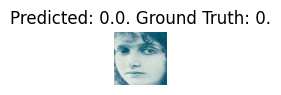

Confidence / Model Output: 0.965


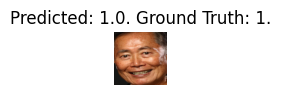

Confidence / Model Output: 0.808


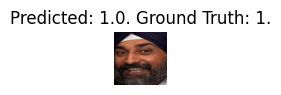

Confidence / Model Output: 0.446


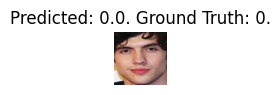

Confidence / Model Output: 0.630


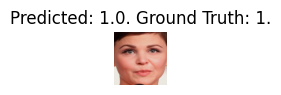

Confidence / Model Output: 0.461


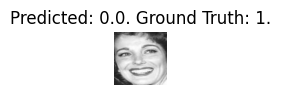

Confidence / Model Output: 0.544


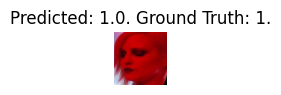

Confidence / Model Output: 0.352


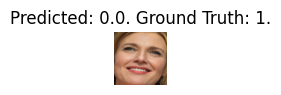

Confidence / Model Output: 0.492


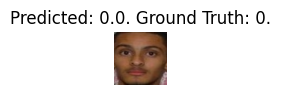

Confidence / Model Output: 0.378


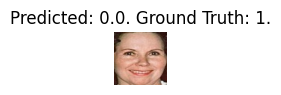

Confidence / Model Output: 0.776


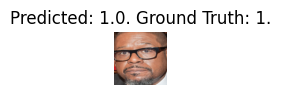

Confidence / Model Output: 0.637


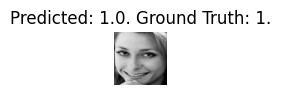

In [34]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=12, show_fails=False)